# 🎧 LyricMind: Music Recommendation System Based on Lyrics
A content-based music recommender using NLP (TF-IDF & Cosine Similarity) built with Python and Streamlit.

Dataset: [Spotify Million Song Dataset (Kaggle)](https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset)


## 📦 Step 1: Import Libraries

We begin by importing the required libraries for data handling, NLP preprocessing, and similarity calculation.


In [2]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLP & Text Similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk

# Optional: For visualizing frequent words
from wordcloud import WordCloud

# Download NLTK stopwords
#nltk.download('stopwords')
# nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


## 📂 Step 2: Load the Dataset

We now load the `spotify_millsongdata.csv` file into a Pandas DataFrame.

This dataset contains over 1 million songs with fields such as:
- `name` — the song title
- `artist` — the artist name
- `text` — the lyrics

Make sure the CSV is placed inside the `data/` folder in your project directory.


In [3]:
# Load dataset from local path
df = pd.read_csv("../dataset/spotify_millsongdata.csv")

# Preview the shape
print(f"Dataset loaded successfully with shape: {df.shape}")

# Preview the first few rows
df.head()


Dataset loaded successfully with shape: (57650, 4)


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


## 🧾 Step 3: Dataset Overview

We now examine the structure of the dataset using `.info()` to understand:
- Column names and data types
- Number of non-null (filled) entries
- Any immediate issues like missing values


In [ ]:
# Show dataframe info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [5]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

## 🎤 Step 4: Top Artists in the Dataset

Before we begin preprocessing lyrics, let's explore the most represented artists in the dataset.

This helps us:
- Understand artist distribution
- Detect potential bias in recommendations (e.g., too many songs from one artist)


In [6]:
# Top 10 artists with most songs in the dataset
top_artists = df['artist'].value_counts().head(10)

print("\nTop 10 Artists:")
print(top_artists)



Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


## 🎲 Step 5: Sample the Dataset and Drop Unused Columns

To speed up processing and visualization, we’ll randomly sample 10,000 songs from the dataset.

We'll also drop the `link` column, as it won’t be used in the recommendation logic.


In [7]:
# Sample 10,000 rows from the full dataset
df = df.sample(10000, random_state=42)

# Drop the 'link' column
df = df.drop('link', axis=1).reset_index(drop=True)

# Display shape and preview
print("Sampled dataset shape:", df.shape)
df.head()


Sampled dataset shape: (10000, 3)


,artist,song,text
0,Wishbone Ash,Right Or Wrong,Like to have you 'round \r\nWith all the lies...
1,Aerosmith,This Little Light Of Mine,"This Little Light of Mine (Light of Mine), \r..."
2,Fall Out Boy,"Dance, Dance",She says she's no good with words but I'm wors...
3,Janis Joplin,Easy Rider,"Hey mama, mama, come a look at sister, \r\nSh..."
4,Moody Blues,Peak Hour,I see it all through my window it seems. \r\n...


## ☁️ Step 6: Word Cloud of Most Common Words in Lyrics

Before diving into text preprocessing, let's visualize the most common words in the lyrics using a word cloud.

This helps us:
- Get an idea of frequent lyrical themes
- Identify common filler words (which we'll remove later)


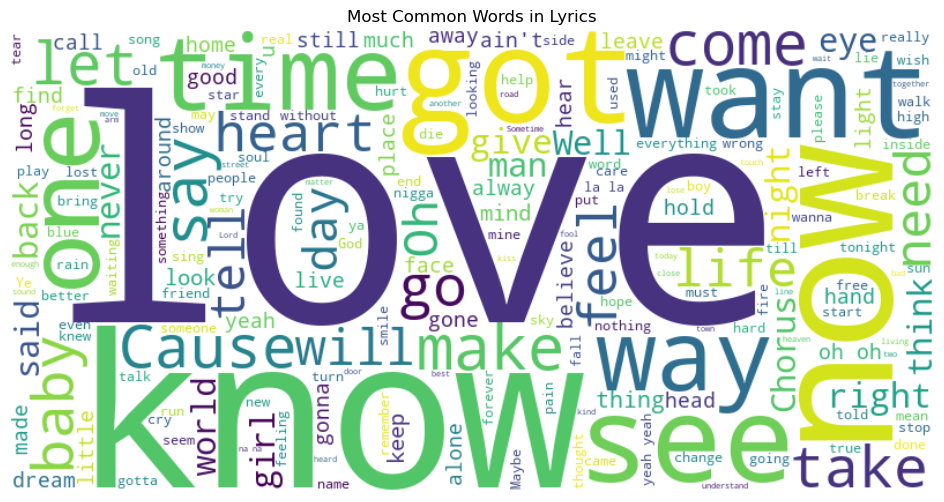

In [8]:
# Combine all lyrics into a single string
all_lyrics = " ".join(df['text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()


## 🧹 Step 7: Preprocess the Lyrics

We now clean the raw lyrics by:
- Lowercasing all text
- Removing special characters and numbers
- Tokenizing the text
- Removing English stopwords (e.g., "the", "is", "in")

This prepares the data for TF-IDF vectorization in the next step.


In [15]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aswin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aswin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aswin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [16]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special chars and digits
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

df[['song', 'artist', 'cleaned_text']].head()

,song,artist,cleaned_text
0,Right Or Wrong,Wishbone Ash,like round lies make things darkness people sa...
1,This Little Light Of Mine,Aerosmith,little light mine light mine im let shine alei...
2,"Dance, Dance",Fall Out Boy,says shes good words im worse barely stuttered...
3,Easy Rider,Janis Joplin,hey mama mama come look sister shes astanding ...
4,Peak Hour,Moody Blues,see window seems never failing like millions e...


## 🎯 Step 8: TF-IDF Vectorization and Similarity Matrix

We convert the cleaned lyrics into numerical vectors using TF-IDF.  
Then, calculate cosine similarity between every pair of songs, enabling us to find similar lyrics easily.


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize TF-IDF vectorizer, limit max features to 5000 for speed and memory
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit & transform the cleaned lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("TF-IDF vectorization and similarity matrix computation completed.")


TF-IDF vectorization and similarity matrix computation completed.


## 🎵 Step 9: Build a Lyrics-Based Song Recommendation Function

Using the cosine similarity matrix, we create a function that takes a song title and returns the top N most similar songs based on their lyrics.

This function:
- Finds the index of the input song
- Retrieves similarity scores with all other songs
- Sorts and picks the top most similar songs (excluding the song itself)
- Returns the artist and song names of those recommendations


In [18]:
# Recommendation function based on cosine similarity of lyrics
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song in the DataFrame (case insensitive)
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return f"Song '{song_name}' not found in the dataset!"
    idx = idx[0]

    # Get similarity scores for all songs with this song
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort songs by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Exclude the first one (itself), get top N
    sim_scores = sim_scores[1:top_n+1]

    # Get indices of the top similar songs
    song_indices = [i[0] for i in sim_scores]

    # Return DataFrame with artist and song columns for recommendations
    return df[['artist', 'song']].iloc[song_indices]

# Example usage:
example_song = df['song'].iloc[2]
print(f"\nRecommendations for the song '{example_song}':")
print(recommend_songs(example_song))



Recommendations for the song 'Dance, Dance':
              artist             song
4174       New Order     Transmission
1501       Halloween  Halloween Dance
8594      Pretenders           Dance!
78           Extreme  Decadence Dance
6079  Michael Bolton    Dance With Me
